In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import RobustScaler


In [2]:
def plot_signal_and_channels(signal, chans, zero=0, delta=5000):
    plt.figure(figsize=(20, 5))

    plt.subplot(2, 1, 1)
    plt.plot(signal[zero:zero+delta], label='Original Signal', color='blue')
    plt.title('Original Signal')
    plt.legend()

    plt.subplot(2, 1, 2) #data.index
    plt.plot(chans[zero:zero+delta], label='Channels', color='orange')
    plt.title('Channels')
    plt.legend()

In [3]:
def create_sequences(data, targets, seq_length=3000, step=100):
    sequences = []
    target_sequences = []
    for i in range(0, len(data) - seq_length + 1, step):
        sequences.append(data[i:i+seq_length])
        target_sequences.append(targets[i:i+seq_length])
    return np.array(sequences), np.array(target_sequences)


In [4]:
def build_model():
    inputs = layers.Input(shape=(None, 2))  # Variable-length sequences
    
    # Normalization
    x = layers.LayerNormalization()(inputs)
    
    # Attention mechanism
    attention = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = layers.Concatenate()([x, attention])
    
    # Temporal processing
    x = layers.Conv1D(64, kernel_size=5, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    
    # Output layer
    outputs = layers.Dense(3, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    
    # Corrected loss function
    def peak_aware_loss(y_true, y_pred):
        # Create weights - higher for actual channel openings
        weights = tf.where(y_true[:, :, 1:] > 0, 5.0, 1.0)  # [batch, seq, 2]
        weights = tf.concat([tf.ones_like(weights[:, :, :1]), weights], axis=-1)  # [batch, seq, 3]
        
        # Calculate base loss
        loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        
        # Apply weights
        weighted_loss = loss * tf.reduce_mean(weights, axis=-1)
        return tf.reduce_mean(weighted_loss)
    
    # Custom metrics for class-specific performance
    def class_recall(class_idx):
        def recall(y_true, y_pred):
            y_true_class = y_true[:, :, class_idx]
            y_pred_class = tf.argmax(y_pred, axis=-1) == class_idx
            y_pred_class = tf.cast(y_pred_class, tf.float32)
            
            true_positives = tf.reduce_sum(y_true_class * y_pred_class)
            possible_positives = tf.reduce_sum(y_true_class)
            
            return true_positives / (possible_positives + tf.keras.backend.epsilon())
        recall.__name__ = f'recall_class_{class_idx}'
        return recall
    
    def class_precision(class_idx):
        def precision(y_true, y_pred):
            y_true_class = y_true[:, :, class_idx]
            y_pred_class = tf.argmax(y_pred, axis=-1) == class_idx
            y_pred_class = tf.cast(y_pred_class, tf.float32)
            
            true_positives = tf.reduce_sum(y_true_class * y_pred_class)
            predicted_positives = tf.reduce_sum(y_pred_class)
            
            return true_positives / (predicted_positives + tf.keras.backend.epsilon())
        precision.__name__ = f'precision_class_{class_idx}'
        return precision
    
    # Focused metrics compilation - only what you care about
    model.compile(optimizer='adam',
                loss=peak_aware_loss,
                metrics=[
                    'accuracy',
                    # Class 0 metrics (if you want them)
                    class_recall(0), class_precision(0),
                    # The important ones - class 1 and 2
                    class_recall(1), class_precision(1),
                    class_recall(2), class_precision(2),
                ])
    
    return model

In [5]:
st = pd.read_csv('data_extracted/1.csv', header=None, names=["time", 'signal', "chans"])

# Calculate relative features
st['signal_diff'] = st['signal'].diff().fillna(0)
st['signal_rolling_mean'] = st['signal'].rolling(window=50, center=True).mean().bfill().ffill()
st['signal_relative'] = st['signal'] - st['signal_rolling_mean']
st['signal_zscore'] = (st['signal'] - st['signal_rolling_mean']) / st['signal'].rolling(window=50, center=True).std().bfill().ffill()

X = st[["signal_relative", "signal_zscore"]].values
y = st["chans"].values

scaler = RobustScaler()
X = scaler.fit_transform(X)

In [6]:
X_seq, y_seq = create_sequences(X, y, seq_length=1000)

y_seq_categorical = tf.keras.utils.to_categorical(y_seq, num_classes=3)  # Assuming max 2 channels

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq_categorical, test_size=0.2, random_state=42)

# Print shapes to verify
print(f"Training data shape: {X_train.shape}")
print(f"Training targets shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test targets shape: {y_test.shape}")

Training data shape: (1032, 1000, 2)
Training targets shape: (1032, 1000, 3)
Test data shape: (258, 1000, 2)
Test targets shape: (258, 1000, 3)


In [7]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 2)]            0         []                            
                                                                                                  
 layer_normalization (Layer  (None, None, 2)              4         ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, None, 2)              2818      ['layer_normalization[0][0]', 
 iHeadAttention)                                                     'layer_normalization[0][0]'] 
                                                                                              

In [8]:
history = model.fit(X_train, y_train,
                   epochs=20,
                   batch_size=16,
                   validation_data=(X_test, y_test),
                   callbacks=[
                       tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
                   ])

Epoch 1/20
65/65 [==============================] - 62s 906ms/step - loss: 0.1217 - accuracy: 0.9781 - recall_class_0: 0.9853 - precision_class_0: 0.9927 - recall_class_1: 0.2479 - precision_class_1: 0.3738 - recall_class_2: 0.0000e+00 - precision_class_2: 0.0000e+00 - val_loss: 0.6841 - val_accuracy: 0.7279 - val_recall_class_0: 0.7258 - val_precision_class_0: 1.0000 - val_recall_class_1: 0.9598 - val_precision_class_1: 0.0453 - val_recall_class_2: 0.0000e+00 - val_precision_class_2: 0.0000e+00
Epoch 2/20
65/65 [==============================] - 57s 884ms/step - loss: 0.0235 - accuracy: 0.9944 - recall_class_0: 0.9965 - precision_class_0: 0.9980 - recall_class_1: 0.7960 - precision_class_1: 0.6957 - recall_class_2: 0.0000e+00 - precision_class_2: 0.0000e+00 - val_loss: 0.1239 - val_accuracy: 0.9913 - val_recall_class_0: 1.0000 - val_precision_class_0: 0.9904 - val_recall_class_1: 0.0000e+00 - val_precision_class_1: 0.0000e+00 - val_recall_class_2: 0.0000e+00 - val_precision_class_2: 0

33/33 [==============================] - 57s 2s/step - loss: 0.2094 - accuracy: 0.9490 - val_loss: 1.0982 - val_accuracy: 0.4959
Epoch 2/20
33/33 [==============================] - 60s 2s/step - loss: 0.0277 - accuracy: 0.9948 - val_loss: 0.0918 - val_accuracy: 0.9883
Epoch 3/20
33/33 [==============================] - 63s 2s/step - loss: 0.0179 - accuracy: 0.9955 - val_loss: 0.0763 - val_accuracy: 0.9934
Epoch 4/20
33/33 [==============================] - 59s 2s/step - loss: 0.0161 - accuracy: 0.9956 - val_loss: 0.1116 - val_accuracy: 0.9934
Epoch 5/20
33/33 [==============================] - 59s 2s/step - loss: 0.0149 - accuracy: 0.9957 - val_loss: 0.1260 - val_accuracy: 0.9934
Epoch 6/20
33/33 [==============================] - 59s 2s/step - loss: 0.0136 - accuracy: 0.9961 - val_loss: 0.1416 - val_accuracy: 0.9934

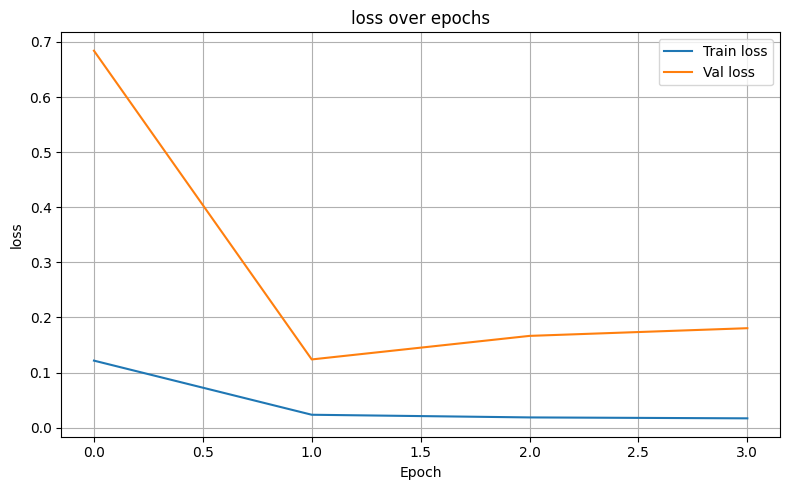

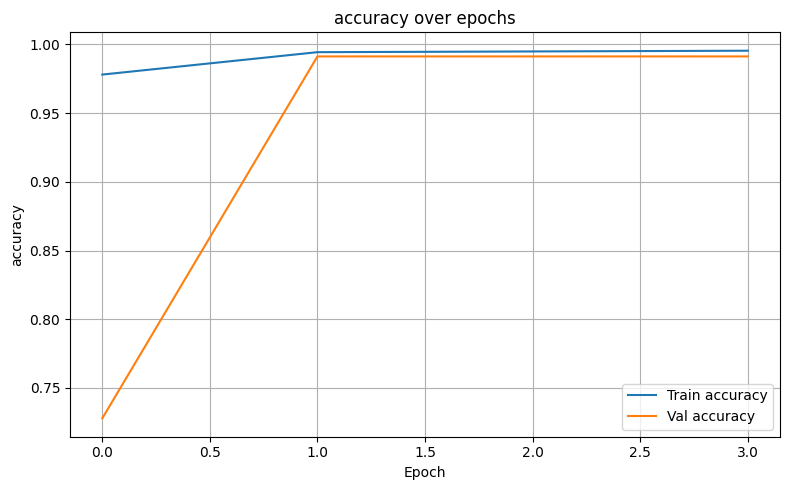

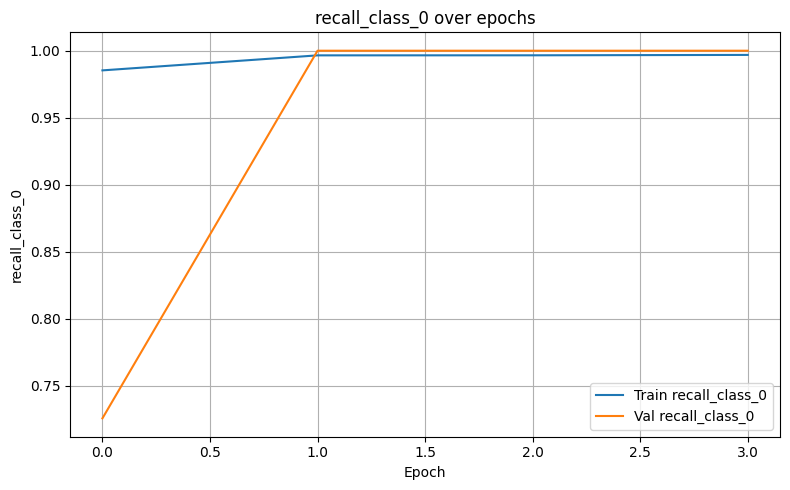

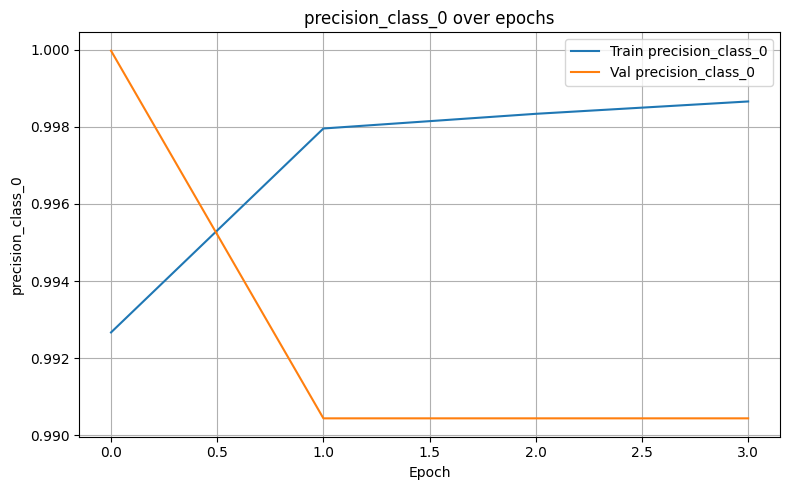

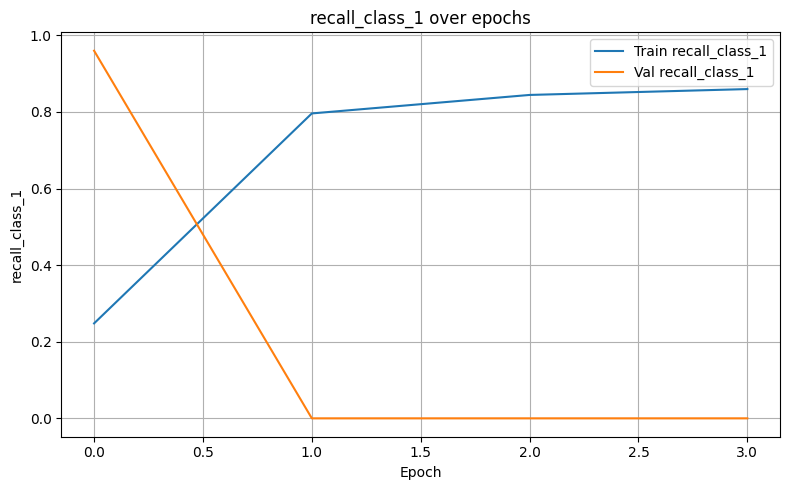

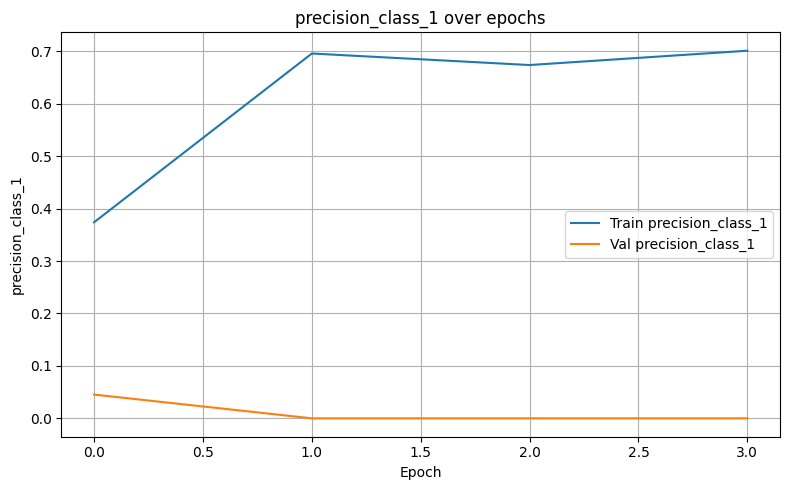

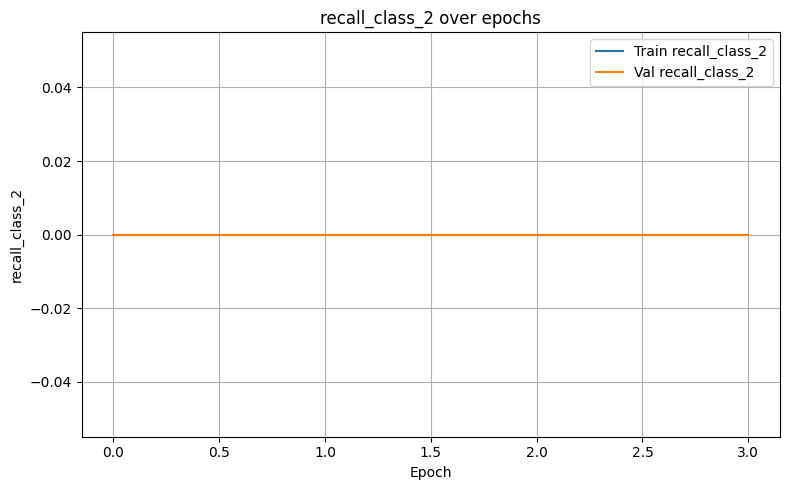

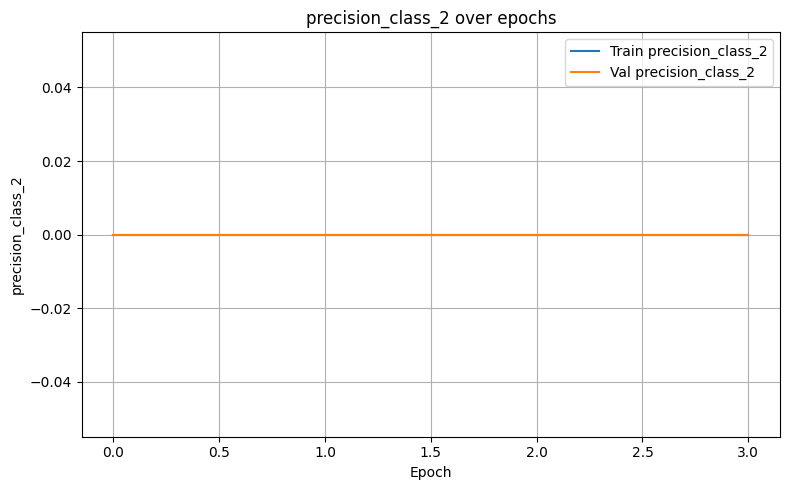

In [9]:
import matplotlib.pyplot as plt

def plot_history(history):
    metrics = [m for m in history.history.keys() if not m.startswith('val_')]
    val_metrics = [f'val_{m}' for m in metrics if f'val_{m}' in history.history]

    for metric in metrics:
        plt.figure(figsize=(8, 5))
        plt.plot(history.history[metric], label=f'Train {metric}')
        if f'val_{metric}' in history.history:
            plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.title(f'{metric} over epochs')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_history(history)

In [56]:
# Prediction function
def predict_channels(signal_sequence, model, scaler, rolling_window=50):
    df = pd.DataFrame({'signal': signal_sequence})
    df['signal_rolling_mean'] = df['signal'].rolling(window=rolling_window, center=True).mean().bfill().ffill()
    df['signal_relative'] = df['signal'] - df['signal_rolling_mean']
    df['signal_zscore'] = (df['signal'] - df['signal_rolling_mean']) / df['signal'].rolling(window=rolling_window, center=True).std().bfill().ffill()
    
    X_new = scaler.transform(df[["signal_relative", "signal_zscore"]].values)
    X_new_seq = np.expand_dims(X_new, axis=0)
    
    preds = model.predict(X_new_seq)[0]
    channel_counts = np.argmax(preds, axis=1)
    
    return channel_counts

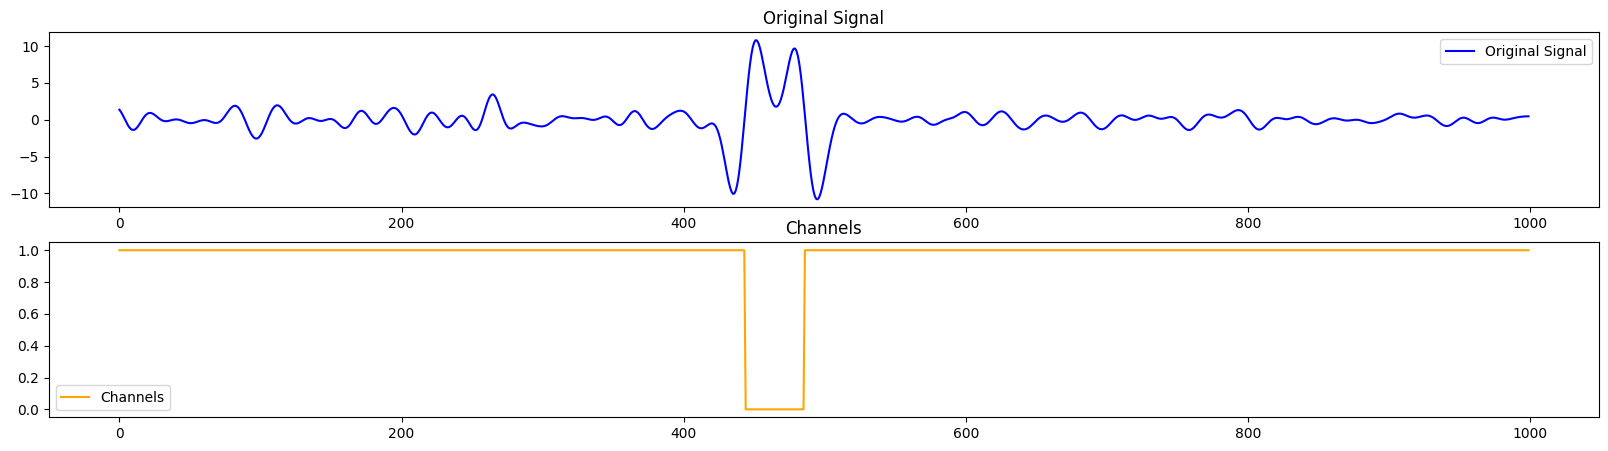

In [57]:
p = 5

probe = X_train[p]
y_probe = y_train[p]
plot_signal_and_channels(probe[:, 0], y_probe[:, 0])

1/1 [==============================] - 0s 53ms/step


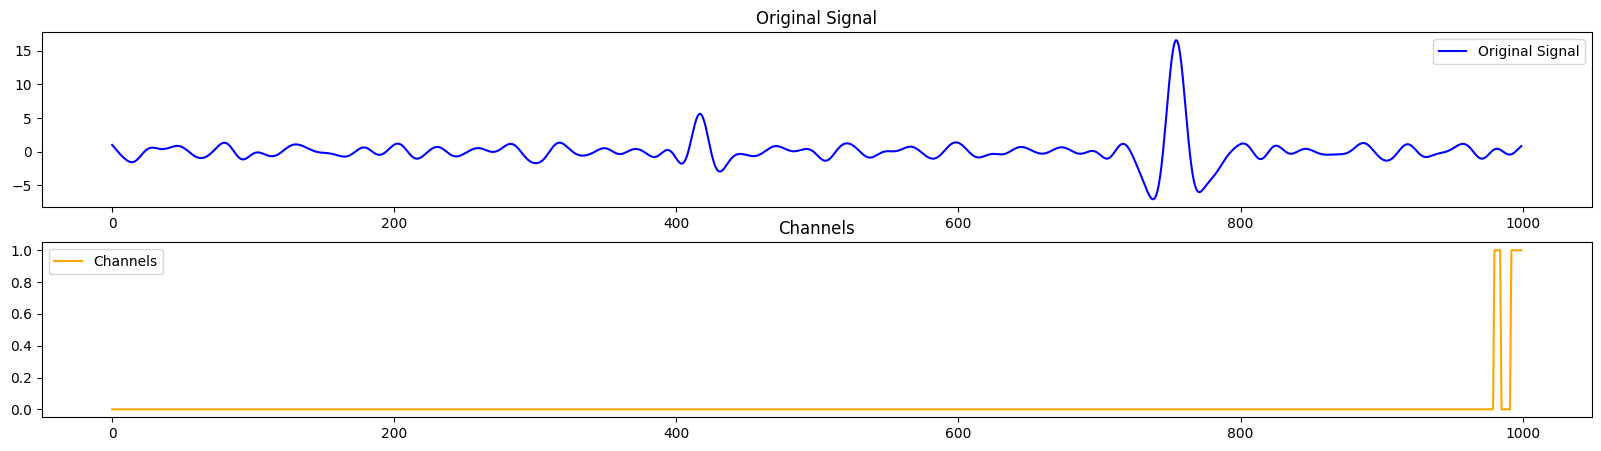

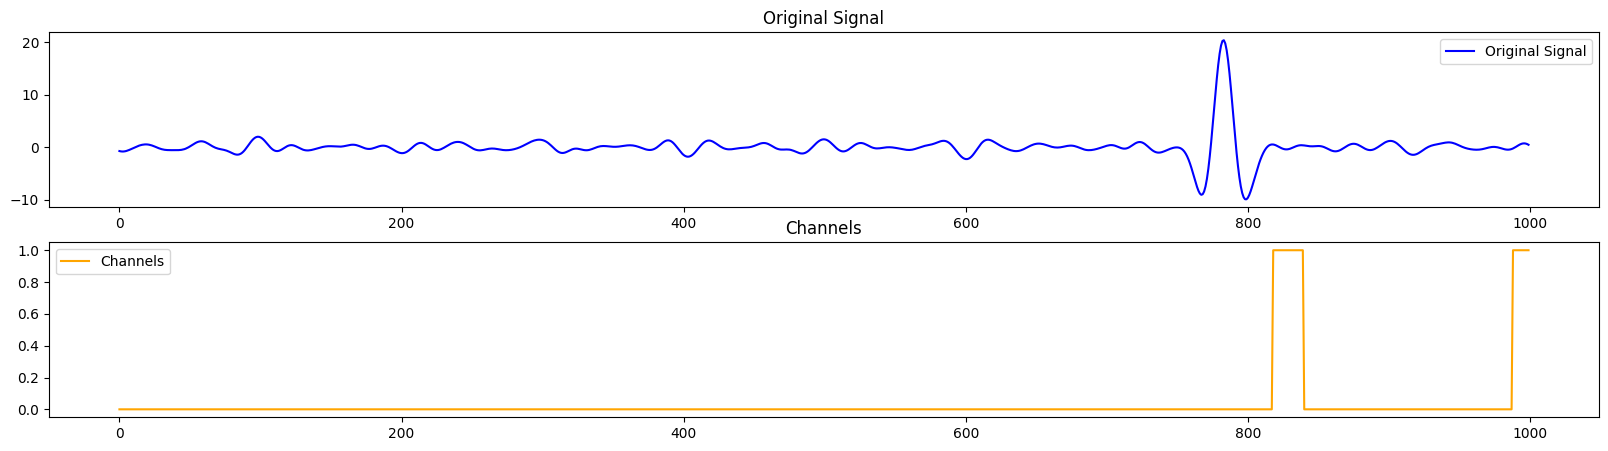

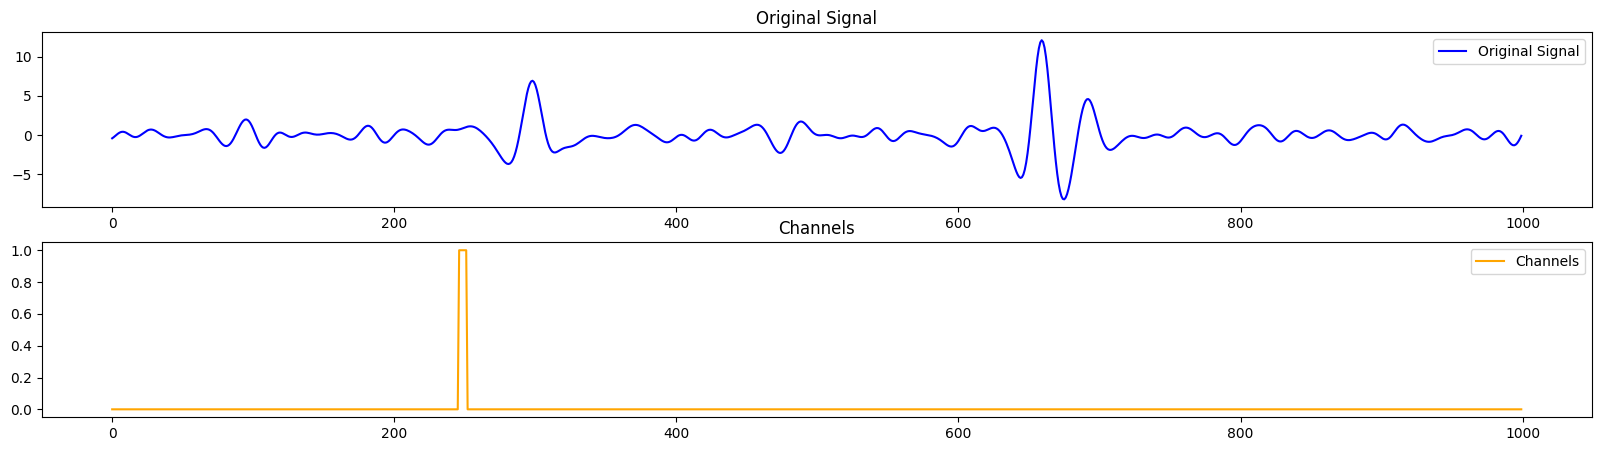

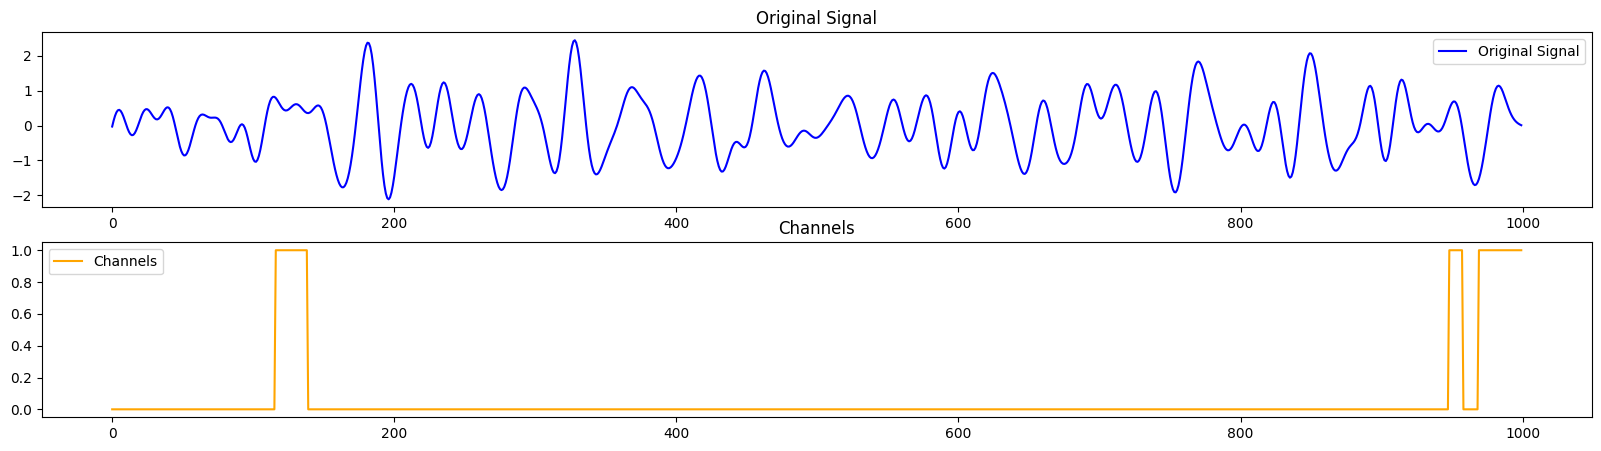

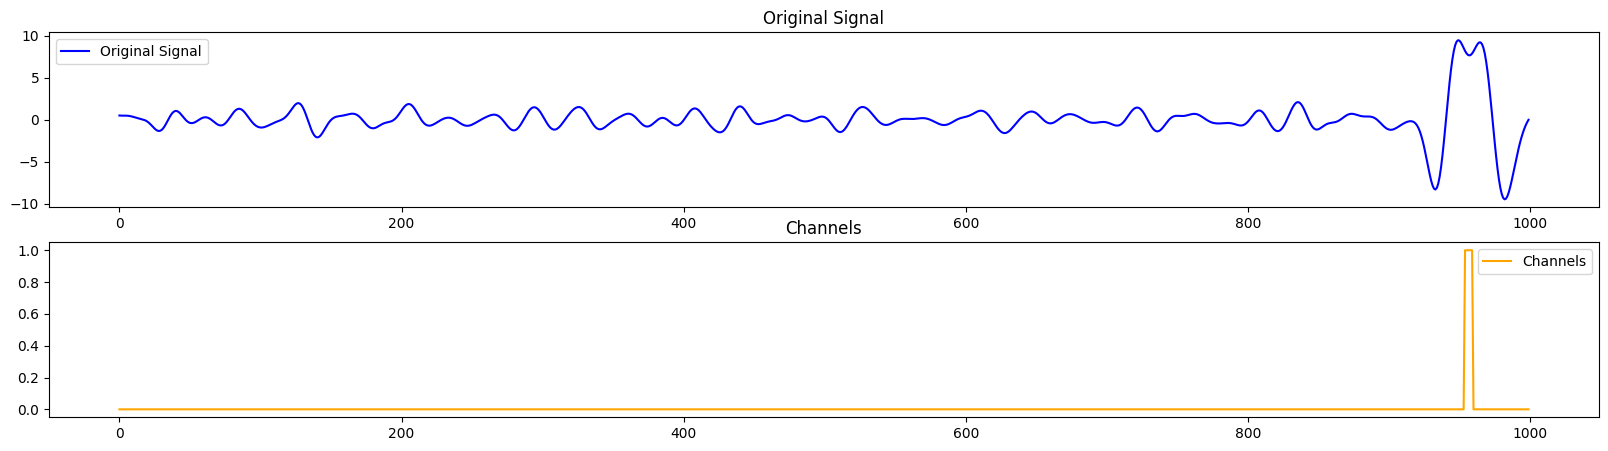

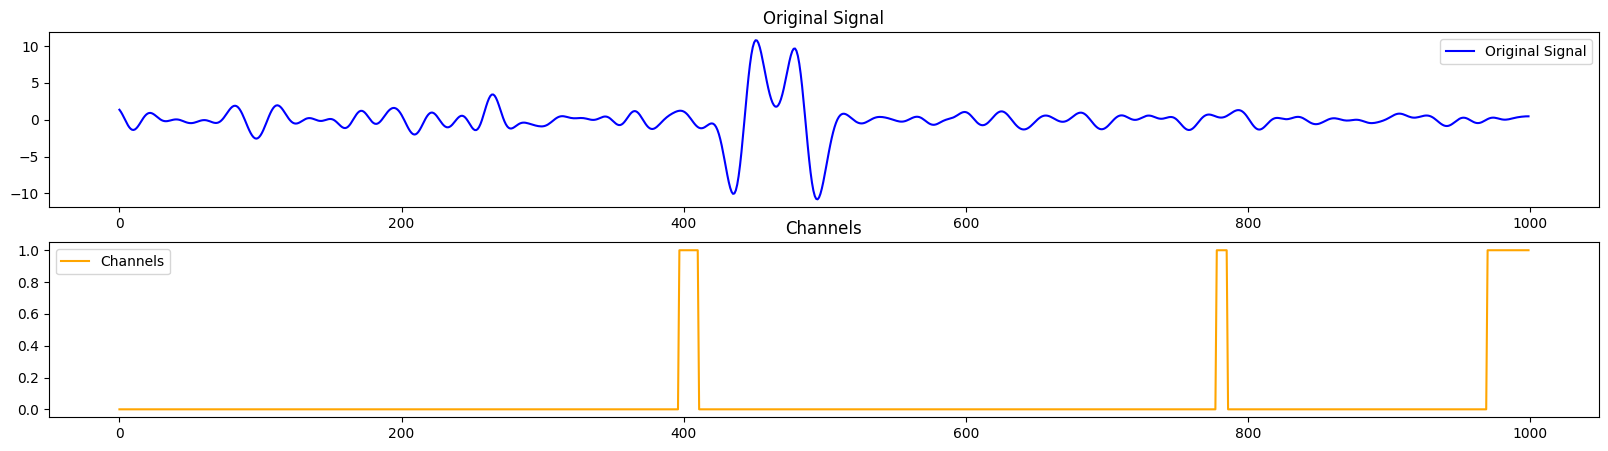

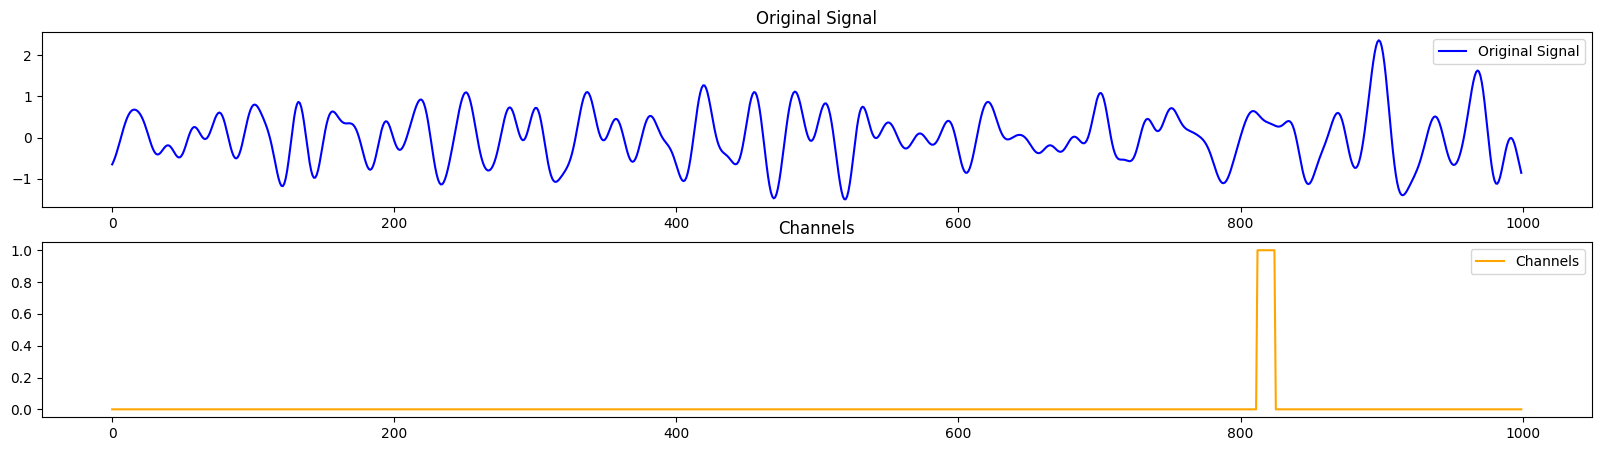

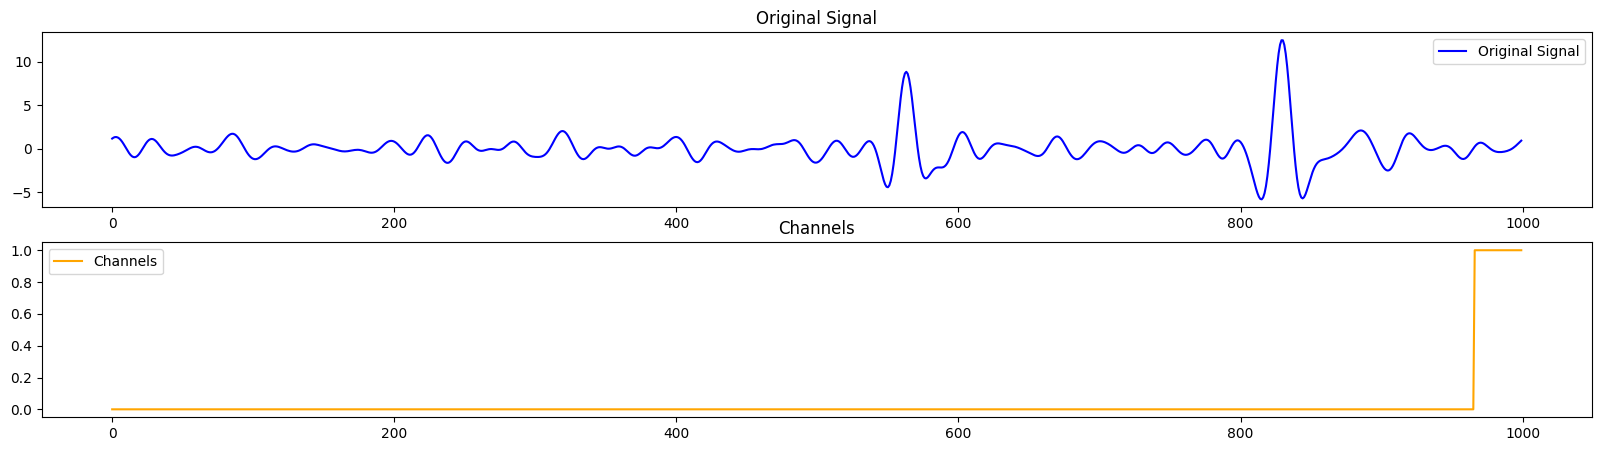

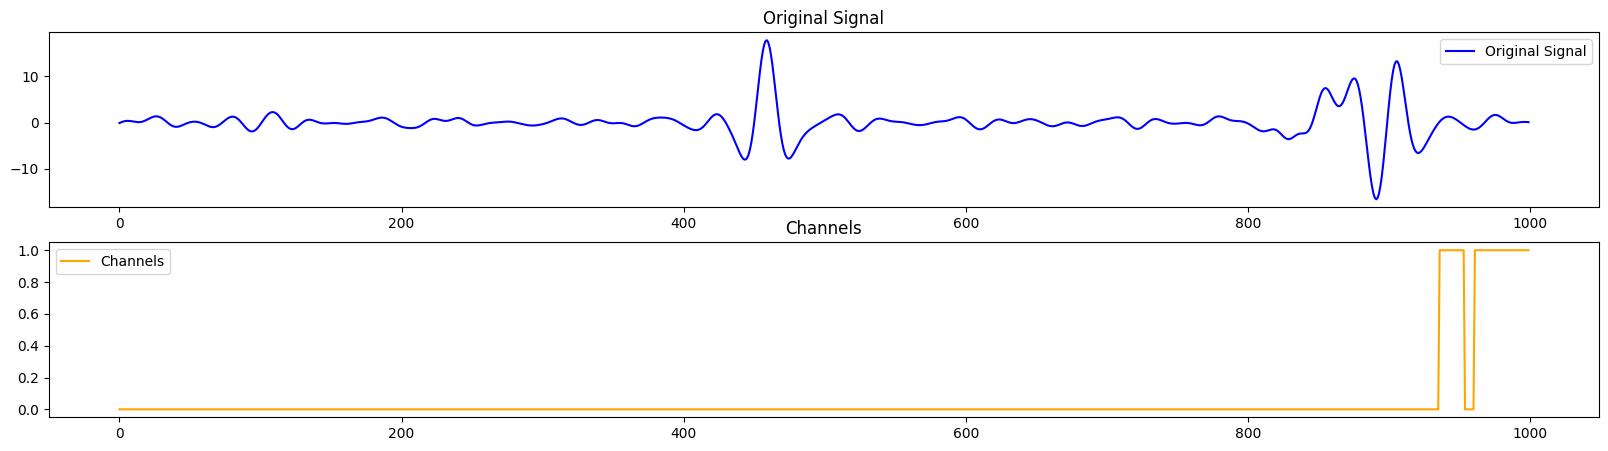

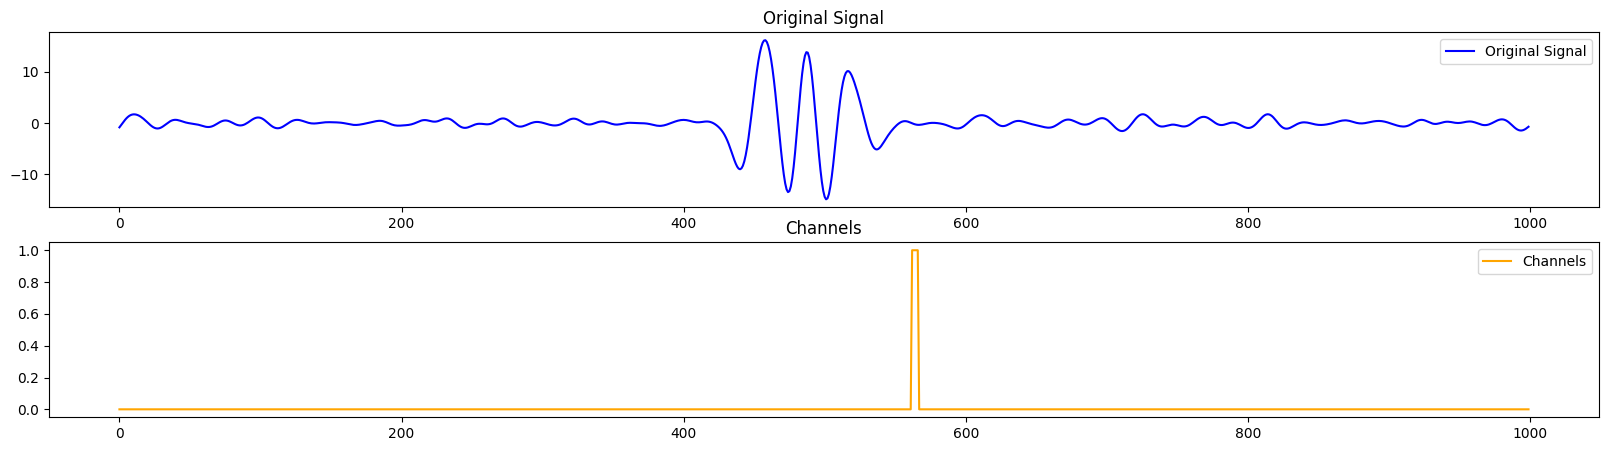

In [58]:
for i in range(10):
    # Test
    test_signal = X_train[i][:, 0]
    predicted_channels = predict_channels(test_signal, model, scaler)

    plot_signal_and_channels(test_signal, predicted_channels)
    # plot_signal_and_channels(test_signal, y_train[i][:, 0])